In [1]:
import numpy as np
from qiskit import *
import random
import time
from numpy import log as ln
import warnings
warnings.filterwarnings('ignore', module = 'qiskit')
# warnings.filterwarnings(action='once')

from qiskit.algorithms.optimizers import ADAM, AQGD, COBYLA, SPSA, TNC, CG, L_BFGS_B, GSLS, NELDER_MEAD, NFT, P_BFGS, POWELL, SLSQP
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI
from qiskit.opflow import CircuitStateFn, StateFn, I, X, Y, Z, H, CX, Zero, One, OperatorBase

from itertools import combinations as cm

In [2]:
# Generate Primes as an array
primes = [2,3,5]#,7,11,17,19,,31,37]
primes = primes[::-1]

combinations = list(cm(range(len(primes)), 2))

In [3]:
def generate_ZZcircuit(params, primes, assigned=True):
    cir = QuantumCircuit(len(primes))
    layers = int(len(params)/((2 * len(primes)) + len(combinations)))
    thetas = [qiskit.circuit.Parameter(str(i)) for i in range(layers * ((2 * len(primes)) + len(combinations)))]
    thetas_reshape = np.reshape(np.asarray(thetas),(layers, ((2 * len(primes)) + len(combinations))))
    params = np.reshape(np.asarray(params),(layers, ((2 * len(primes)) + len(combinations))))
    combs = list(cm(range(len(primes)), 2))
    cir.h(range(len(primes)))
    
    for m in range(layers):
        l = len(params[m])
        g = thetas_reshape[m][0: len(primes)]
        g_prime = [ln(2)*ln(30), ln(3)*ln(30),ln(5)*ln(30)]
        a = thetas_reshape[m][len(primes): (len(primes) + len(combs))]
        a_prime = [ln(2)*ln(3), ln(2)*ln(5), ln(3)*ln(5)]
        b = thetas_reshape[m][(len(primes) + len(combs)) : l]
        
        for h in range(len(primes)):
            cir.rz(g_prime[h]*g[h], h)
        
        i = 0
        for j, k in combs:
            cir.rzz(a_prime[i]*a[i], j, k)
            i += 1
        for l in range(len(primes)):
            cir.rx(b[l], l)
            
    if assigned == True:
        thetas_reshape = thetas_reshape.flatten()
        params = params.flatten()
        p_dict = {thetas_reshape[i] : params[i] for i in range(len(thetas))}
        cir.assign_parameters(p_dict, inplace=True)
    cir.measure_all()
    
    return cir, thetas

[2.903684131568895, 2.721877095499787, 2.595584074622988, 1.4446744596259582, 2.690955957117111, 0.5750774481712586, 0.37237752074972286, 1.9016600868748115, 2.4727427832247724]


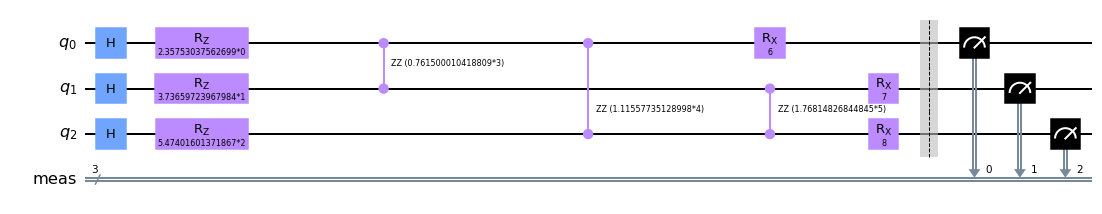

In [4]:
hyperparam = [random.uniform(0,np.pi) for _ in range(1 * ((2 * len(primes)) + len(combinations)))]
print(hyperparam)
cir, free_params = generate_ZZcircuit(hyperparam, primes, assigned=False)
cir.draw('mpl')

In [5]:
def obj_function(counts, n, penalty):
    max_c = 0
    max_bit = ""
    for c in counts:
        if counts[c] >= max_c:
            max_c =  counts[c]
            max_bit = c
    comp_primes = 1
    for i in range(len(max_bit)):
        comp_primes *= primes[i]**int(max_bit[i])
    p = 0
    if penalty == 1:
        if abs(comp_primes-n) > n:
            p += comp_primes
    return abs((n - comp_primes) + p)

In [6]:
def gen_f(n):
    
    def f(theta):
        qc, free_params = generate_ZZcircuit(theta, primes)
        back = Aer.get_backend('aer_simulator')
        back.set_options(device='GPU')
        job_sim = execute(qc, backend = back, shots = 2048).result()
        counts = job_sim.get_counts(qc)
        
        return obj_function(counts, n, 1)

    return f

In [7]:
def X_generator(primes, identity):
    #Generate X value for hamiltonian
    constant = 0

    for i in range(len(primes)):
        #Build Constant value iteratively
        constant += ln(primes[i])
        
        if i == 0:
            z_value = Z
        else:
            z_value = I
        #Build rest of X
        for j in range(1, len(primes)):
            if j == i:
                z_value = z_value ^ Z
            else:
                z_value = z_value ^ I
        if i == 0:
            x = -ln(primes[i]) * z_value
        else:
            x -= ln(primes[i]) * z_value
    #Combine Both to form X
    x += constant * identity
    
    return x

def hamiltonian(n, primes):
    #Generate Hamitonian according to number of primes
    identity = I
    
    for i in range(len(primes) - 1):
        identity = identity ^ I
        
    x = X_generator(primes, identity)
    
    lnn = float(ln(n))
    
    h = ((lnn**2) * identity) - (lnn * x) + (1 / 4 * (x ** 2))
    
    return h

In [8]:
h_value = hamiltonian(5, primes)
print(h_value.to_matrix())

[[ 2.59029039e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  8.39588705e-01+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  2.60942818e-01+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   3.32411501e-02+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j -4.44089210e-16+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  4.80453014e-01+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j

In [9]:
 def _convert_to_gradient_function(gradient_object, layers, n):

        def gradient_function(current_point):

            cir, free_params = generate_ZZcircuit(current_point, primes, assigned=False)
            cir.remove_final_measurements()
            c = hamiltonian(n, primes)
            op = ~StateFn(c) @ CircuitStateFn(primitive=cir, coeff=1.)
            grad_object = gradient_object.convert(operator=op, params=free_params)
            value_dict = {free_params[i]: current_point[i] for i in range(len(free_params))}
            x = grad_object.assign_parameters(value_dict).eval()
#             print(x)
#             analytical_gradients = np.array(x)# Change this part
            return np.real(x)
        
        return gradient_function

In [10]:
def run(optimizer, layers, func, gradient_function, n):
    g_f = _convert_to_gradient_function(gradient_function, layers, n)
    theta = [random.uniform(0, 2 * np.pi) for _ in range(layers * ((2 * len(primes)) + len(combinations)))]
    theta, loss, _ = optimizer.optimize(
                num_vars=len(theta),
                objective_function=func,
                initial_point=theta,
                gradient_function=g_f
                )
    return loss

import math
mom = []
itr = []
et = []
for i in range(100):
    mom.append(abs(0.5 * (100-i) / 100))
    et.append(abs(0.5 *(100-i) / 100))
    itr.append(i)

gradient_types = ['param_shift'] #['', 'param_shift', 'lin_comb', 'fin_diff']
op_types = [100, 300, 500, 700, 900, 1000, 2000]#AQGD(maxiter = 500, momentum=0.02)]#, COBYLA(maxiter = 100), TNC(maxiter = 100), CG(maxiter = 100), GSLS(maxiter = 100), NELDER_MEAD(maxiter = 100)]#, NFT(maxiter = 500)]#, P_BFGS(maxfun = 500), POWELL(maxiter = 500), SLSQP(maxiter = 500)]
loss_list = []
for n in range(12, 13):
    fun = gen_f(n) 
    grad = Gradient(grad_method="param_shift")
    n_list=[]
    for e in op_types:
        temp = []
        for _ in range(10):
            print(e)
            opt = TNC(maxiter=e)
            loss = run(opt, 1, fun, grad, n)
            temp.append(loss)
        n_list.append(temp)
    loss_list.append(n_list)
# for i in range(2, 16):
#     print("Current n = ", i)
#     fun = gen_f(i)
#     n_list = []
#     for j in range(1,2):
#         print("Current layer = ", j)
#         layer_list = []
#         for k in range(len(op_types)):
#             print("Current opt = ", k)
#             opt = op_types[k]
#             grad_list = []
#             for g in range(len(gradient_types)):
#                 print("Current Gradient = ", gradient_types[g] )
# #                 if g == 0:
# #                     grad = Gradient()
# #                 else:
#                 grad = Gradient(grad_method=gradient_types[g])
#                 samples = []
#                 for _ in range(10):
#                     start = time.perf_counter()
#                     loss = run(opt,  j, fun, grad, i)
#                     end = time.perf_counter()
#                     samples.append((loss, end - start))
#                 grad_list.append(samples)
#             layer_list.append(grad_list)
#         n_list.append(layer_list)
#     loss_list.append(n_list)

100
100
100
100
100
100
100
100
100
100
300
300
300
300
300
300
300
300
300
300
500
500
500
500
500
500
500
500
500
500
700
700
700
700
700
700
700
700
700
700
900
900
900
900
900
900
900
900
900
900
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000


In [11]:
print(loss_list)

[[[2, 2, 2, 12, 2, 6, 3, 6, 2, 9], [2, 10, 3, 9, 2, 9, 2, 2, 2, 12], [2, 6, 7, 2, 9, 2, 6, 2, 6, 3], [6, 2, 6, 3, 2, 6, 2, 2, 3, 6], [7, 7, 2, 2, 3, 2, 6, 6, 6, 2], [3, 2, 9, 3, 6, 2, 2, 2, 2, 3], [2, 9, 9, 9, 6, 2, 3, 6, 6, 2]]]


In [12]:
ll = np.asarray(loss_list)
ll.shape

(1, 7, 10)

In [13]:
np.save("Test_opt_TNC_maxiter_12", ll,)